# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

### embedを得るためのnote

In [1]:
! nvidia-smi

Tue Jun  7 07:35:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Directory settings

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os
import sys
import json
# INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
# OUTPUT_DIR = './'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

# CFG

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=500
    epochs=4
    encoder_lr=1.5e-5
    decoder_lr=15e-5 # decoder_lrを10倍してみる
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.0
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=10
    trn_fold=[0, 1, 2, 3]
    train=True
    newtrain = True

    name = "exp018c" # 実験のたびにコピーしてここの名前を変えて実行するとoutputが別のファイルに保存される
    api_path = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path = "/content/drive/MyDrive/kaggle/PPPM"
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [4]:
COLAB = "google.colab" in sys.modules

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 2.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=f6146173715829a356461ceeb017f9334eade20634b196713e594765ac3a0587
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    
    # use kaggle api (need kaggle token)
    f = open(CFG.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = CFG.drive_path
    EXP = CFG.name
    INPUT_DIR = os.path.join(DRIVE, "Input")
    OUTPUT_DIR = os.path.join(DRIVE, "Output")
    SCRIPT = os.path.join(DRIVE, "Script")
    OUTPUT_DIR = os.path.join(OUTPUT_DIR, EXP) 
    # EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    # EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    # EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT_DIR, SCRIPT, OUTPUT_DIR]:
        os.makedirs(d, exist_ok=True)

    if not os.path.isfile(os.path.join(INPUT_DIR, "us-patent-phrase-to-phrase-matching.zip")):
        # load dataset
        ! kaggle competitions download -c us-patent-phrase-to-phrase-matching -p $INPUT_DIR 
        unzip_file = os.path.join(INPUT_DIR, 'us-patent-phrase-to-phrase-matching.zip')
        ! unzip $unzip_file -d $INPUT_DIR
    
    if not os.path.isfile(os.path.join(INPUT_DIR, "cpc-data.zip")):
        # load dataset
        ! kaggle datasets download -d yasufuminakama/cpc-data -p $INPUT_DIR
        unzip_file = os.path.join(INPUT_DIR, 'cpc-data.zip')
        ! unzip $unzip_file -d $INPUT_DIR

else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
    OUTPUT_DIR = './'
    
    
    # # copy dirs
    # if Config.kaggle_dataset_path is not None:
    #     KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
    #     KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
    #     shutil.copytree(KD_MODEL, EXP_MODEL)
    #     shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # # make dirs
    # for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
    #     os.makedirs(d, exist_ok=True)
        
    

This environment is Google Colab
Mounted at /content/drive


In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
# !pip install transformers==4.18.0
!pip install transformers[sentencepiece]
!pip install tokenizers==0.12.1
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

import lightgbm as lgb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.9 MB/s 
     |████████████████████████████████| 86 kB 2.4 MB/s 
     |████████████████████████████████| 6.6 MB 41.3 MB/s 
     |████████████████████████████████| 596 kB 46.3 MB/s 
     |████████████████████████████████| 1.2 MB 49.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.2
env: TOKENIZERS_PARALLELISM=true


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'/train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [10]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'/train.csv')
test = pd.read_csv(INPUT_DIR+'/test.csv')
submission = pd.read_csv(INPUT_DIR+'/sample_submission.csv')
# print(f"train.shape: {train.shape}")
# print(f"test.shape: {test.shape}")
# print(f"submission.shape: {submission.shape}")
# display(train.head())
# display(test.head())
# display(submission.head())

In [11]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    if COLAB:
        cpcpath = os.path.join(INPUT_DIR, 'CPCSchemeXML202105')
    else:
        cpcpath = '../input/cpc-data/CPCSchemeXML202105'
    for file_name in os.listdir(cpcpath):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        if COLAB:
            cpcpath = os.path.join(INPUT_DIR, f'CPCTitleList202202/cpc-section-{cpc}_20220201.txt')
        else:
            cpcpath = f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt'
        with open(cpcpath) as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"/cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [12]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
# display(train.head())
# display(test.head())

# EDA

In [13]:
# train['score'].hist()

In [14]:
# display(train['context'].apply(lambda x: x[0]).value_counts())

- Y is not in training data, but may be in test data?

# CV split

In [15]:
# # ====================================================
# # CV split
# # ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())

In [16]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'], train['anchor'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    3560
1    3994
2    3501
3    3691
4    3786
5    3582
6    3489
7    4030
8    3323
9    3517
dtype: int64

In [17]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [18]:
# ====================================================
# tokenizer
# ====================================================
! pip install sentencepiece
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'/tokenizer/')
CFG.tokenizer = tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [19]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [20]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [21]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [22]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()
        # in_features は各トークンに対するベクトルの次元数
        # max_length は最大トークン数
        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [23]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        in_features = self.config.hidden_size
        self.attention = TransformerHead(in_features=in_features, max_length=cfg.max_len, num_layers=1, nhead=8, num_targets=1)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
        self._init_weights(self.fc)
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        feature = self.attention(last_hidden_states)
        
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
#         print(feature.shape)
        output = self.fc(self.fc_dropout(feature))
        return output, feature

In [24]:
class Pearson_Loss(nn.Module):
    def __init__(self):
        super(Pearson_Loss, self).__init__()

    def forward(self, label, preds):
        preds_mean = torch.mean(preds)
        label_mean = torch.mean(label)

        num = torch.sum(torch.mul((preds-preds_mean),(label-label_mean)))

        pred_std = torch.sum(torch.square((preds-preds_mean)))
        label_std = torch.sum(torch.square((label-label_mean)))
        den = torch.sqrt(pred_std * label_std)
        loss = 1-torch.divide(num, den)

        return loss

# Helpler functions

In [25]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterions, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds, _ = model(inputs)
        # loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        loss = None
        for criterion in criterions:
            if loss == None:
                loss = criterion(y_preds.view(-1, 1).to(torch.half), labels.view(-1, 1).to(torch.half))
            else:
                loss += criterion(y_preds.view(-1, 1).to(torch.half), labels.view(-1, 1).to(torch.half))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterions, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        # loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        loss = None
        for criterion in criterions:
            if loss == None:
                loss = criterion(y_preds.view(-1, 1).to(torch.half), labels.view(-1, 1).to(torch.half))
            else:
                loss += criterion(y_preds.view(-1, 1).to(torch.half), labels.view(-1, 1).to(torch.half))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [26]:
### lightgbm
### 適当なやつ
def train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    from lightgbm import LGBMRegressor
    model.eval()

    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            y_preds, embed = model(inputs)
        embeds.append(embed.to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',  # default = 'gbdt'
    'num_leaves': 2**8-1, #63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
    'max_depth': 8,
#     'min_data_in_leaf': 50,   # default = 20
    'verbosity': -1,
}
    

    train_data = lgb.Dataset(
        data=embeds, 
        label=targets, 
    )

    bst = lgb.train(params=params, 
                    train_set=train_data, 
                    num_boost_round=600)

    return bst, embeds, targets

def valid_fn_(valid_loader, model, criterion, device, gbdt):
    model.eval()
    preds = []
    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            _, embed = model(inputs)
        embeds.append(embed.to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())

        y_preds = gbdt.predict(embed.to('cpu').numpy())
        preds.append(y_preds)

    predictions = np.concatenate(preds)
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
#     predictions = np.concatenate(predictions)
    return predictions, embeds, targets


# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values

    # newtrain ============================================
    if CFG.newtrain:
        path = os.path.join(INPUT_DIR, 'newtrain.csv')
        df = pd.read_csv(path)
        r = [0.95, 0.97, 0.7, 0.60, 0.98]
        m = ['0', '1', '2', '3', '4']
        new_df = []
        for i, j in zip(m, r):
            idx = df[i] > j
            df.loc[idx, 'score'] = int(i) * 0.25
            new_df.append(df[idx])
        new_train = pd.concat(new_df)
        train_folds = pd.concat([train_folds[['text', 'score']], new_train[['text', 'score']]])
    # ======================================================
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    model.config.update(
        {
            "attention_probs_dropout_prob" : 0.0,
            "hidden_dropout_prob": 0.0
        }
    )
    torch.save(model.config, OUTPUT_DIR+'/config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = [nn.BCEWithLogitsLoss(reduction="mean"), nn.MSELoss(reduction='mean'), Pearson_Loss()]
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # lightgbm train
        gbdt, embeds_tr, targets_tr = train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        predictions, embeds_va, targets_va = valid_fn_(valid_loader, model, criterion, device, gbdt)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            gbdt.save_model(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best_gbdt.txt")
        
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_embeds_tr", embeds_tr)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_targets_tr", targets_tr)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_embeds_va", embeds_va)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_targets_va", targets_va)

    predictions = torch.load(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions'] #bestmodelのpredictionをとりだす
    ### round
#     predictions *= 4
#     predictions = predictions.round() / 4
    valid_folds['pred'] = predictions
    valid_folds['pred'].hist(bins=100)

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds


========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2724] Elapsed 0m 1s (remain 80m 56s) Loss: 2.2188(2.2188) Grad: nan  LR: 0.00000003  
Epoch: [1][100/2724] Elapsed 1m 39s (remain 42m 59s) Loss: 1.3350(1.8140) Grad: 80580.1484  LR: 0.00000303  
Epoch: [1][200/2724] Elapsed 3m 17s (remain 41m 14s) Loss: 1.8555(1.6381) Grad: 77279.0078  LR: 0.00000603  
Epoch: [1][300/2724] Elapsed 4m 53s (remain 39m 26s) Loss: 0.8730(1.4850) Grad: 40054.4922  LR: 0.00000903  
Epoch: [1][400/2724] Elapsed 6m 30s (remain 37m 41s) Loss: 1.5039(1.3749) Grad: 81540.4453  LR: 0.00001203  
Epoch: [1][500/2724] Elapsed 8m 6s (remain 35m 59s) Loss: 0.9341(1.2959) Grad: 35454.3047  LR: 0.00001500  
Epoch: [1][600/2724] Elapsed 9m 43s (remain 34m 19s) Loss: 1.0078(1.2398) Grad: 34501.1875  LR: 0.00001500  
Epoch: [1][700/2724] Elapsed 11m 19s (remain 32m 40s) Loss: 0.9062(1.1973) Grad: 26275.1172  LR: 0.00001499  
Epoch: [1][800/2724] Elapsed 12m 55s (remain 31m 2s) Loss: 0.9233(1.1606) Grad: 34938.0156  LR: 0.00001497  
Epoch: [1][900/2724] Elapsed 

Epoch 1 - Score: 0.8140


Epoch: [2][0/2724] Elapsed 0m 1s (remain 52m 12s) Loss: 0.7759(0.7759) Grad: nan  LR: 0.00001337  
Epoch: [2][100/2724] Elapsed 1m 37s (remain 42m 14s) Loss: 0.7344(0.7872) Grad: 134585.7188  LR: 0.00001322  
Epoch: [2][200/2724] Elapsed 3m 14s (remain 40m 35s) Loss: 0.7031(0.7866) Grad: 20302.1484  LR: 0.00001307  
Epoch: [2][300/2724] Elapsed 4m 50s (remain 38m 57s) Loss: 0.7798(0.7875) Grad: 38833.4609  LR: 0.00001292  
Epoch: [2][400/2724] Elapsed 6m 26s (remain 37m 20s) Loss: 0.7812(0.7917) Grad: 31670.3418  LR: 0.00001276  
Epoch: [2][500/2724] Elapsed 8m 3s (remain 35m 45s) Loss: 0.7251(0.7966) Grad: 32928.6094  LR: 0.00001260  
Epoch: [2][600/2724] Elapsed 9m 39s (remain 34m 8s) Loss: 0.7666(0.7960) Grad: 23711.2520  LR: 0.00001243  
Epoch: [2][700/2724] Elapsed 11m 16s (remain 32m 31s) Loss: 0.7573(0.7958) Grad: 23359.9785  LR: 0.00001226  
Epoch: [2][800/2724] Elapsed 12m 52s (remain 30m 55s) Loss: 0.8794(0.7950) Grad: 74093.0859  LR: 0.00001208  
Epoch: [2][900/2724] Elapsed

Epoch 2 - Score: 0.8314


Epoch: [3][0/2724] Elapsed 0m 1s (remain 53m 27s) Loss: 0.7695(0.7695) Grad: nan  LR: 0.00000806  
Epoch: [3][100/2724] Elapsed 1m 37s (remain 42m 14s) Loss: 0.7661(0.7592) Grad: 30223.2871  LR: 0.00000784  
Epoch: [3][200/2724] Elapsed 3m 13s (remain 40m 32s) Loss: 0.6948(0.7641) Grad: 21853.8320  LR: 0.00000761  
Epoch: [3][300/2724] Elapsed 4m 50s (remain 38m 54s) Loss: 0.9849(0.7638) Grad: 389934.1250  LR: 0.00000738  
Epoch: [3][400/2724] Elapsed 6m 26s (remain 37m 17s) Loss: 0.7969(0.7603) Grad: 74646.2656  LR: 0.00000716  
Epoch: [3][500/2724] Elapsed 8m 2s (remain 35m 40s) Loss: 1.0117(0.7589) Grad: 222010.7031  LR: 0.00000693  
Epoch: [3][600/2724] Elapsed 9m 38s (remain 34m 4s) Loss: 0.8594(0.7582) Grad: 107716.1250  LR: 0.00000671  
Epoch: [3][700/2724] Elapsed 11m 14s (remain 32m 27s) Loss: 0.8838(0.7566) Grad: 79655.2500  LR: 0.00000648  
Epoch: [3][800/2724] Elapsed 12m 51s (remain 30m 51s) Loss: 0.6958(0.7559) Grad: 33314.3086  LR: 0.00000626  
Epoch: [3][900/2724] Elaps

Epoch 3 - Score: 0.8281


Epoch: [4][0/2724] Elapsed 0m 1s (remain 50m 38s) Loss: 0.7075(0.7075) Grad: nan  LR: 0.00000240  
Epoch: [4][100/2724] Elapsed 1m 37s (remain 42m 6s) Loss: 0.7510(0.7280) Grad: 67307.8281  LR: 0.00000224  
Epoch: [4][200/2724] Elapsed 3m 13s (remain 40m 28s) Loss: 0.8633(0.7323) Grad: 22263.1133  LR: 0.00000208  
Epoch: [4][300/2724] Elapsed 4m 49s (remain 38m 51s) Loss: 0.7769(0.7309) Grad: 7440.1572  LR: 0.00000192  
Epoch: [4][400/2724] Elapsed 6m 25s (remain 37m 15s) Loss: 0.7573(0.7314) Grad: 9693.7148  LR: 0.00000177  
Epoch: [4][500/2724] Elapsed 8m 2s (remain 35m 39s) Loss: 0.7183(0.7353) Grad: 17480.5781  LR: 0.00000163  
Epoch: [4][600/2724] Elapsed 9m 38s (remain 34m 2s) Loss: 0.7407(0.7355) Grad: 25121.1738  LR: 0.00000149  
Epoch: [4][700/2724] Elapsed 11m 14s (remain 32m 27s) Loss: 0.6621(0.7354) Grad: 9916.3232  LR: 0.00000136  
Epoch: [4][800/2724] Elapsed 12m 51s (remain 30m 51s) Loss: 0.6997(0.7356) Grad: 17152.5742  LR: 0.00000123  
Epoch: [4][900/2724] Elapsed 14m 

Epoch 4 - Score: 0.8315
========== fold: 0 result ==========
Score: 0.8315
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/2697] Elapsed 0m 2s (remain 101m 9s) Loss: 1.7598(1.7598) Grad: nan  LR: 0.00000003  
Epoch: [1][100/2697] Elapsed 1m 38s (remain 42m 14s) Loss: 1.5918(1.7938) Grad: 78888.0938  LR: 0.00000303  
Epoch: [1][200/2697] Elapsed 3m 14s (remain 40m 19s) Loss: 0.9834(1.6218) Grad: 51107.4023  LR: 0.00000603  
Epoch: [1][300/2697] Elapsed 4m 51s (remain 38m 37s) Loss: 0.8750(1.4323) Grad: 35864.6602  LR: 0.00000903  
Epoch: [1][400/2697] Elapsed 6m 27s (remain 36m 58s) Loss: 0.8784(1.3195) Grad: 25583.5781  LR: 0.00001203  
Epoch: [1][500/2697] Elapsed 8m 3s (remain 35m 20s) Loss: 0.7759(1.2417) Grad: 19324.5254  LR: 0.00001500  
Epoch: [1][600/2697] Elapsed 9m 40s (remain 33m 42s) Loss: 1.1055(1.1910) Grad: 34370.3828  LR: 0.00001500  
Epoch: [1][700/2697] Elapsed 11m 16s (remain 32m 5s) Loss: 0.9214(1.1503) Grad: 34194.4648  LR: 0.00001499  
Epoch: [1][800/2697] Elapsed 12m 52s (remain 30m 28s) Loss: 1.5938(1.1462) Grad: 29862.5195  LR: 0.00001497  
Epoch: [1][900/2697] Elapsed 

Epoch 1 - Score: 0.8142


Epoch: [2][0/2697] Elapsed 0m 1s (remain 52m 9s) Loss: 0.7783(0.7783) Grad: nan  LR: 0.00001337  
Epoch: [2][100/2697] Elapsed 1m 37s (remain 41m 50s) Loss: 0.7979(0.8121) Grad: 66327.0312  LR: 0.00001323  
Epoch: [2][200/2697] Elapsed 3m 13s (remain 40m 8s) Loss: 0.7334(0.8147) Grad: 23080.5391  LR: 0.00001308  
Epoch: [2][300/2697] Elapsed 4m 50s (remain 38m 30s) Loss: 0.8911(0.8129) Grad: 49499.9492  LR: 0.00001292  
Epoch: [2][400/2697] Elapsed 6m 26s (remain 36m 53s) Loss: 1.2051(0.8133) Grad: 238164.6250  LR: 0.00001276  
Epoch: [2][500/2697] Elapsed 8m 2s (remain 35m 16s) Loss: 0.7876(0.8125) Grad: 91471.5625  LR: 0.00001260  
Epoch: [2][600/2697] Elapsed 9m 39s (remain 33m 40s) Loss: 0.7373(0.8117) Grad: 15564.3584  LR: 0.00001242  
Epoch: [2][700/2697] Elapsed 11m 15s (remain 32m 3s) Loss: 0.8071(0.8122) Grad: 23168.9453  LR: 0.00001225  
Epoch: [2][800/2697] Elapsed 12m 52s (remain 30m 27s) Loss: 0.9023(0.8098) Grad: 199706.6562  LR: 0.00001207  
Epoch: [2][900/2697] Elapsed 

Epoch 2 - Score: 0.8271


Epoch: [3][0/2697] Elapsed 0m 1s (remain 53m 51s) Loss: 0.7476(0.7476) Grad: nan  LR: 0.00000807  
Epoch: [3][100/2697] Elapsed 1m 37s (remain 41m 52s) Loss: 0.6919(0.7758) Grad: 33448.9609  LR: 0.00000784  
Epoch: [3][200/2697] Elapsed 3m 14s (remain 40m 9s) Loss: 0.7642(0.7799) Grad: 42088.4453  LR: 0.00000761  
Epoch: [3][300/2697] Elapsed 4m 50s (remain 38m 32s) Loss: 0.8579(0.7772) Grad: 51663.1289  LR: 0.00000738  
Epoch: [3][400/2697] Elapsed 6m 27s (remain 36m 56s) Loss: 0.7124(0.7757) Grad: 27089.3750  LR: 0.00000715  
Epoch: [3][500/2697] Elapsed 8m 3s (remain 35m 19s) Loss: 0.8047(0.7776) Grad: 31191.6562  LR: 0.00000693  
Epoch: [3][600/2697] Elapsed 9m 39s (remain 33m 42s) Loss: 0.7617(0.7771) Grad: 11201.7773  LR: 0.00000670  
Epoch: [3][700/2697] Elapsed 11m 16s (remain 32m 5s) Loss: 0.7329(0.7777) Grad: 14137.0068  LR: 0.00000647  
Epoch: [3][800/2697] Elapsed 12m 52s (remain 30m 28s) Loss: 0.7637(0.7786) Grad: 58452.6211  LR: 0.00000624  
Epoch: [3][900/2697] Elapsed 1

Epoch 3 - Score: 0.8307


Epoch: [4][0/2697] Elapsed 0m 1s (remain 53m 59s) Loss: 0.7954(0.7954) Grad: nan  LR: 0.00000240  
Epoch: [4][100/2697] Elapsed 1m 37s (remain 41m 53s) Loss: 0.7017(0.7519) Grad: 49711.9297  LR: 0.00000224  
Epoch: [4][200/2697] Elapsed 3m 14s (remain 40m 10s) Loss: 0.7407(0.7541) Grad: 100968.9062  LR: 0.00000208  
Epoch: [4][300/2697] Elapsed 4m 50s (remain 38m 31s) Loss: 0.8286(0.7570) Grad: nan  LR: 0.00000192  
Epoch: [4][400/2697] Elapsed 6m 26s (remain 36m 54s) Loss: 0.7363(0.7541) Grad: 45310.5508  LR: 0.00000177  
Epoch: [4][500/2697] Elapsed 8m 3s (remain 35m 17s) Loss: 0.7378(0.7583) Grad: 46933.8594  LR: 0.00000162  
Epoch: [4][600/2697] Elapsed 9m 39s (remain 33m 40s) Loss: 0.7983(0.7584) Grad: 79815.2109  LR: 0.00000148  
Epoch: [4][700/2697] Elapsed 11m 15s (remain 32m 4s) Loss: 0.6963(0.7593) Grad: 43483.8906  LR: 0.00000135  
Epoch: [4][800/2697] Elapsed 12m 52s (remain 30m 27s) Loss: 0.7212(0.7577) Grad: 18421.9609  LR: 0.00000122  
Epoch: [4][900/2697] Elapsed 14m 28

Epoch 4 - Score: 0.8331
========== fold: 1 result ==========
Score: 0.8331
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/2727] Elapsed 0m 2s (remain 131m 11s) Loss: 1.9121(1.9121) Grad: nan  LR: 0.00000003  
Epoch: [1][100/2727] Elapsed 1m 39s (remain 42m 56s) Loss: 1.8008(1.7528) Grad: 129259.6875  LR: 0.00000303  
Epoch: [1][200/2727] Elapsed 3m 15s (remain 40m 57s) Loss: 1.1787(1.6879) Grad: 84870.3203  LR: 0.00000603  
Epoch: [1][300/2727] Elapsed 4m 51s (remain 39m 12s) Loss: 0.9229(1.5199) Grad: 48375.6992  LR: 0.00000903  
Epoch: [1][400/2727] Elapsed 6m 28s (remain 37m 32s) Loss: 0.7998(1.3934) Grad: 18567.5332  LR: 0.00001203  
Epoch: [1][500/2727] Elapsed 8m 4s (remain 35m 53s) Loss: 0.9438(1.3088) Grad: 30275.5254  LR: 0.00001500  
Epoch: [1][600/2727] Elapsed 9m 41s (remain 34m 15s) Loss: 0.8232(1.2479) Grad: 16785.2715  LR: 0.00001500  
Epoch: [1][700/2727] Elapsed 11m 17s (remain 32m 37s) Loss: 0.7905(1.2036) Grad: 14634.6387  LR: 0.00001499  
Epoch: [1][800/2727] Elapsed 12m 53s (remain 31m 0s) Loss: 0.8354(1.1688) Grad: 14739.5938  LR: 0.00001497  
Epoch: [1][900/2727] Elapse

Epoch 1 - Score: 0.8340


Epoch: [2][0/2727] Elapsed 0m 1s (remain 64m 41s) Loss: 0.7817(0.7817) Grad: nan  LR: 0.00001337  
Epoch: [2][100/2727] Elapsed 1m 37s (remain 42m 25s) Loss: 0.8037(0.7906) Grad: 52003.5352  LR: 0.00001322  
Epoch: [2][200/2727] Elapsed 3m 14s (remain 40m 42s) Loss: 0.7598(0.7952) Grad: 59771.3320  LR: 0.00001308  
Epoch: [2][300/2727] Elapsed 4m 50s (remain 39m 3s) Loss: 0.7002(0.7957) Grad: 26262.5703  LR: 0.00001292  
Epoch: [2][400/2727] Elapsed 6m 27s (remain 37m 26s) Loss: 0.7188(0.7922) Grad: 37714.9336  LR: 0.00001276  
Epoch: [2][500/2727] Elapsed 8m 3s (remain 35m 48s) Loss: 0.8164(0.7902) Grad: 67348.7578  LR: 0.00001260  
Epoch: [2][600/2727] Elapsed 9m 40s (remain 34m 12s) Loss: 0.8252(0.7879) Grad: 73017.8438  LR: 0.00001243  
Epoch: [2][700/2727] Elapsed 11m 16s (remain 32m 35s) Loss: 0.8560(0.7889) Grad: 41511.8047  LR: 0.00001226  
Epoch: [2][800/2727] Elapsed 12m 53s (remain 30m 58s) Loss: 0.7866(0.7902) Grad: 69620.0469  LR: 0.00001208  
Epoch: [2][900/2727] Elapsed 

Epoch 2 - Score: 0.8260


Epoch: [3][0/2727] Elapsed 0m 1s (remain 54m 20s) Loss: 0.9609(0.9609) Grad: nan  LR: 0.00000807  
Epoch: [3][100/2727] Elapsed 1m 37s (remain 42m 18s) Loss: 0.7231(0.7447) Grad: 42014.0938  LR: 0.00000784  
Epoch: [3][200/2727] Elapsed 3m 14s (remain 40m 38s) Loss: 0.7192(0.7514) Grad: 24242.5898  LR: 0.00000761  
Epoch: [3][300/2727] Elapsed 4m 50s (remain 39m 1s) Loss: 0.7993(0.7522) Grad: 121997.6250  LR: 0.00000739  
Epoch: [3][400/2727] Elapsed 6m 27s (remain 37m 25s) Loss: 0.6948(0.7524) Grad: 10335.6270  LR: 0.00000716  
Epoch: [3][500/2727] Elapsed 8m 3s (remain 35m 48s) Loss: 0.7500(0.7534) Grad: 56968.8711  LR: 0.00000694  
Epoch: [3][600/2727] Elapsed 9m 40s (remain 34m 11s) Loss: 0.7056(0.7524) Grad: 24888.5586  LR: 0.00000671  
Epoch: [3][700/2727] Elapsed 11m 16s (remain 32m 34s) Loss: 1.0234(0.7523) Grad: 58363.9180  LR: 0.00000649  
Epoch: [3][800/2727] Elapsed 12m 52s (remain 30m 58s) Loss: 0.7153(0.7538) Grad: 37235.1328  LR: 0.00000626  
Epoch: [3][900/2727] Elapsed

Epoch 3 - Score: 0.8303


Epoch: [4][0/2727] Elapsed 0m 1s (remain 54m 47s) Loss: 0.6597(0.6597) Grad: nan  LR: 0.00000240  
Epoch: [4][100/2727] Elapsed 1m 37s (remain 42m 18s) Loss: 0.7104(0.7318) Grad: 36892.8945  LR: 0.00000224  
Epoch: [4][200/2727] Elapsed 3m 14s (remain 40m 38s) Loss: 0.7188(0.7374) Grad: 39041.6367  LR: 0.00000208  
Epoch: [4][300/2727] Elapsed 4m 50s (remain 39m 1s) Loss: 0.6982(0.7374) Grad: 26439.0215  LR: 0.00000193  
Epoch: [4][400/2727] Elapsed 6m 26s (remain 37m 24s) Loss: 0.6948(0.7360) Grad: 10435.3584  LR: 0.00000178  
Epoch: [4][500/2727] Elapsed 8m 3s (remain 35m 47s) Loss: 0.7441(0.7372) Grad: 44130.4180  LR: 0.00000163  
Epoch: [4][600/2727] Elapsed 9m 39s (remain 34m 10s) Loss: 0.7603(0.7363) Grad: 36470.7773  LR: 0.00000150  
Epoch: [4][700/2727] Elapsed 11m 16s (remain 32m 34s) Loss: 0.7905(0.7356) Grad: 38026.0820  LR: 0.00000136  
Epoch: [4][800/2727] Elapsed 12m 52s (remain 30m 57s) Loss: 0.7427(0.7347) Grad: 38112.7422  LR: 0.00000124  
Epoch: [4][900/2727] Elapsed 

Epoch 4 - Score: 0.8308
========== fold: 2 result ==========
Score: 0.8340
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/2716] Elapsed 0m 2s (remain 95m 12s) Loss: 1.8076(1.8076) Grad: nan  LR: 0.00000003  
Epoch: [1][100/2716] Elapsed 1m 38s (remain 42m 29s) Loss: 2.3828(1.7910) Grad: 107344.9766  LR: 0.00000303  
Epoch: [1][200/2716] Elapsed 3m 15s (remain 40m 41s) Loss: 1.4023(1.7267) Grad: 36845.7070  LR: 0.00000603  
Epoch: [1][300/2716] Elapsed 4m 51s (remain 39m 0s) Loss: 0.9370(1.5450) Grad: 18123.0879  LR: 0.00000903  
Epoch: [1][400/2716] Elapsed 6m 28s (remain 37m 20s) Loss: 1.2266(1.4327) Grad: 27023.4512  LR: 0.00001203  
Epoch: [1][500/2716] Elapsed 8m 4s (remain 35m 42s) Loss: 0.8345(1.3472) Grad: 7761.8481  LR: 0.00001500  
Epoch: [1][600/2716] Elapsed 9m 41s (remain 34m 4s) Loss: 0.7749(1.2834) Grad: 8061.4043  LR: 0.00001500  
Epoch: [1][700/2716] Elapsed 11m 17s (remain 32m 27s) Loss: 0.7534(1.2328) Grad: 11319.3525  LR: 0.00001499  
Epoch: [1][800/2716] Elapsed 12m 53s (remain 30m 50s) Loss: 0.9189(1.1903) Grad: 19032.8945  LR: 0.00001497  
Epoch: [1][900/2716] Elapsed 14

Epoch 1 - Score: 0.8005


Epoch: [2][0/2716] Elapsed 0m 1s (remain 57m 0s) Loss: 0.7378(0.7378) Grad: nan  LR: 0.00001337  
Epoch: [2][100/2716] Elapsed 1m 37s (remain 42m 9s) Loss: 0.7764(0.8208) Grad: 14771.3320  LR: 0.00001322  
Epoch: [2][200/2716] Elapsed 3m 14s (remain 40m 27s) Loss: 0.7666(0.8138) Grad: 15519.3525  LR: 0.00001308  
Epoch: [2][300/2716] Elapsed 4m 50s (remain 38m 49s) Loss: 0.8262(0.8118) Grad: 18198.8887  LR: 0.00001292  
Epoch: [2][400/2716] Elapsed 6m 26s (remain 37m 11s) Loss: 0.8159(0.8075) Grad: 19502.7422  LR: 0.00001276  
Epoch: [2][500/2716] Elapsed 8m 2s (remain 35m 34s) Loss: 0.8184(0.8042) Grad: 27533.3613  LR: 0.00001260  
Epoch: [2][600/2716] Elapsed 9m 39s (remain 33m 58s) Loss: 0.7505(0.8042) Grad: 14563.5654  LR: 0.00001243  
Epoch: [2][700/2716] Elapsed 11m 15s (remain 32m 21s) Loss: 0.8149(0.8032) Grad: 39899.9805  LR: 0.00001225  
Epoch: [2][800/2716] Elapsed 12m 52s (remain 30m 46s) Loss: 0.8203(0.7991) Grad: 33227.9258  LR: 0.00001208  
Epoch: [2][900/2716] Elapsed 1

Epoch 2 - Score: 0.8151


Epoch: [3][0/2716] Elapsed 0m 1s (remain 53m 48s) Loss: 0.7085(0.7085) Grad: nan  LR: 0.00000807  
Epoch: [3][100/2716] Elapsed 1m 37s (remain 42m 11s) Loss: 0.7319(0.7602) Grad: 49062.1016  LR: 0.00000784  
Epoch: [3][200/2716] Elapsed 3m 14s (remain 40m 27s) Loss: 0.8511(0.7607) Grad: 62845.4922  LR: 0.00000761  
Epoch: [3][300/2716] Elapsed 4m 50s (remain 38m 49s) Loss: 0.7412(0.7625) Grad: 40898.5781  LR: 0.00000738  
Epoch: [3][400/2716] Elapsed 6m 26s (remain 37m 12s) Loss: 0.6431(0.7598) Grad: 11645.2266  LR: 0.00000716  
Epoch: [3][500/2716] Elapsed 8m 3s (remain 35m 36s) Loss: 0.7134(0.7605) Grad: 31255.7812  LR: 0.00000693  
Epoch: [3][600/2716] Elapsed 9m 39s (remain 33m 59s) Loss: 0.7881(0.7601) Grad: 42360.5508  LR: 0.00000670  
Epoch: [3][700/2716] Elapsed 11m 15s (remain 32m 23s) Loss: 0.7822(0.7588) Grad: 30674.6426  LR: 0.00000648  
Epoch: [3][800/2716] Elapsed 12m 52s (remain 30m 46s) Loss: 0.7959(0.7596) Grad: 69904.8516  LR: 0.00000625  
Epoch: [3][900/2716] Elapsed

Epoch 3 - Score: 0.8139


Epoch: [4][0/2716] Elapsed 0m 1s (remain 52m 58s) Loss: 0.7529(0.7529) Grad: nan  LR: 0.00000240  
Epoch: [4][100/2716] Elapsed 1m 37s (remain 42m 3s) Loss: 0.6768(0.7514) Grad: 18066.6250  LR: 0.00000224  
Epoch: [4][200/2716] Elapsed 3m 14s (remain 40m 27s) Loss: 0.7119(0.7471) Grad: 31430.9434  LR: 0.00000208  
Epoch: [4][300/2716] Elapsed 4m 50s (remain 38m 49s) Loss: 0.7617(0.7461) Grad: 27982.0449  LR: 0.00000192  
Epoch: [4][400/2716] Elapsed 6m 26s (remain 37m 12s) Loss: 0.8271(0.7458) Grad: 46853.1055  LR: 0.00000177  
Epoch: [4][500/2716] Elapsed 8m 3s (remain 35m 35s) Loss: 0.7544(0.7447) Grad: 60709.0156  LR: 0.00000163  
Epoch: [4][600/2716] Elapsed 9m 39s (remain 33m 58s) Loss: 0.7563(0.7425) Grad: 34475.9961  LR: 0.00000149  
Epoch: [4][700/2716] Elapsed 11m 15s (remain 32m 21s) Loss: 0.8130(0.7433) Grad: 37948.2578  LR: 0.00000136  
Epoch: [4][800/2716] Elapsed 12m 51s (remain 30m 45s) Loss: 0.7554(0.7443) Grad: 55103.6094  LR: 0.00000123  
Epoch: [4][900/2716] Elapsed 

Epoch 4 - Score: 0.8126
========== fold: 3 result ==========
Score: 0.8151
========== CV ==========
Score: 0.8280


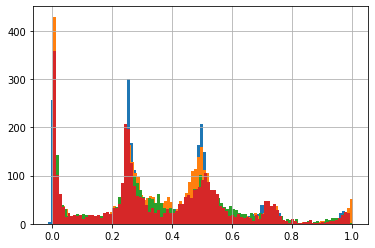

In [27]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'/oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()